# Build a P-value interpreter function with ChatGPT

In [1]:
def interpret_p_value(p_value, threshold=0.05):
    """
    Interpret the p-value in a statistical context against a specific threshold.

    Parameters:
    p_value (float): The p-value to interpret, expected to be in the range 0 to 1.
    threshold (float): The significance level threshold, default is 0.05.

    Returns:
    None: Prints the interpretation of the p-value.

    Raises:
    ValueError: If the p_value or threshold is not within the range [0, 1].

    Description:
    This function assesses the provided p-value against a given threshold:
    - p < threshold: Evidence suggests rejecting the null hypothesis.
    - p >= threshold: Not enough evidence to reject the null hypothesis.

    It's important to note that the interpretation of p-values is context-dependent
    and should be considered along with other factors in statistical analysis.
    """
    if not (0 <= p_value <= 1):
        raise ValueError("p_value must be between 0 and 1.")
    if not (0 <= threshold <= 1):
        raise ValueError("threshold must be between 0 and 1.")

    if p_value < threshold:
        print(f"p-value ({p_value}) is less than the threshold ({threshold}).")
        print("Evidence suggests rejecting the null hypothesis.")
    else:
        print(f"p-value ({p_value}) is greater than or equal to the threshold ({threshold}).")
        print("Not enough evidence to reject the null hypothesis.")

# Example usage
interpret_p_value(0.03, threshold=0.05)

p-value (0.03) is less than the threshold (0.05).
Evidence suggests rejecting the null hypothesis.


# Libraries and Data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

In [3]:
# Load the data
df = pd.read_csv("amazon_landing_page.csv")
df.head()

,user_id,group,landing_page,converted
0,851104,control,old_page,0
1,804228,control,old_page,0
2,661590,treatment,new_page,0
3,853541,treatment,new_page,0
4,864975,control,old_page,1


In [4]:
# df information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   group         294480 non-null  object
 2   landing_page  294480 non-null  object
 3   converted     294480 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.0+ MB


# EDA

In [5]:
# 1. Descriptive Statistics and Data Quality Check
desc_stats = df.describe()
print(desc_stats)
print(f"\nMissing values in each column:\n {df.isnull().sum()}")
print(f"\nNumber of duplicate entries: {df.duplicated().sum()}")

             user_id      converted
count  294480.000000  294480.000000
mean   787973.538896       0.119658
std     91210.917091       0.324562
min    630000.000000       0.000000
25%    709031.750000       0.000000
50%    787932.500000       0.000000
75%    866911.250000       0.000000
max    945999.000000       1.000000

Missing values in each column:
 user_id         0
group           0
landing_page    0
converted       0
dtype: int64

Number of duplicate entries: 2


In [6]:
# Checking consistency between group and landing_page
consistency_check = (df['group'] == 'control') == (df['landing_page'] == 'old_page')
print(f"\nConsistency between group and landing_page:  {consistency_check.all()}")

# where the control group goes into the old page. putting people in the control when they shouldnt be.



Consistency between group and landing_page:  False


In [7]:
# 2. Group Analysis
group_conversion = df.groupby('group')['converted'].mean()
print("\nConversion rate by group:\n", group_conversion)


Conversion rate by group:
 group
control      0.120399
treatment    0.118918
Name: converted, dtype: float64


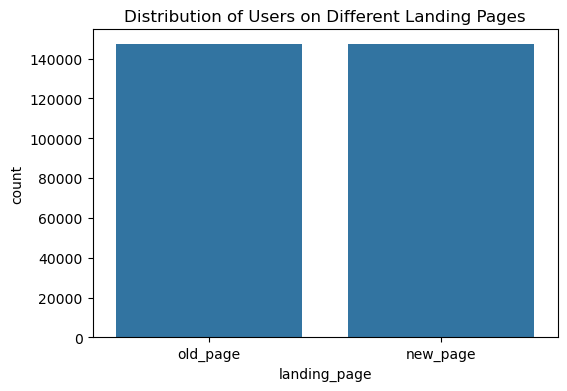

In [8]:
# Distribution of users on different landing pages
plt.figure(figsize=(6, 4))
sns.countplot(x='landing_page', data=df)
plt.title('Distribution of Users on Different Landing Pages')
plt.show()

# Data Preprocessing

In [9]:
# Removing duplicate entries for user_id
df_unique = df.drop_duplicates(subset='user_id')

In [10]:
# Checking for inconsistencies between group and landing_page
inconsistencies = df_unique[((df_unique['group'] == 'control') & (df_unique['landing_page'] != 'old_page')) |
                    ((df_unique['group'] == 'treatment') & (df_unique['landing_page'] != 'new_page'))]

# Counting the number of inconsistencies
num_inconsistencies = inconsistencies.shape[0]
print(f"Number of inconsistencies: {num_inconsistencies}") 


Number of inconsistencies: 2044


In [11]:
# Option 1: Remove the inconsistent rows
df_fixed = df_unique.drop(inconsistencies.index)

# Bayesian A/B Testing

In [12]:
# Import libraries
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

2024-08-26 13:05:41.511880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Get the total conversions and total observations for each grup
conversions_A = df_fixed[(df_fixed['group'] == 'control') & (df_fixed['converted'] == 1)].shape[0]
conversions_B = df_fixed[(df_fixed['group'] == 'treatment') & (df_fixed['converted'] == 1)].shape[0]
total_A = df_fixed[(df_fixed['group'] == 'control')].shape[0]
total_B = df_fixed[(df_fixed['group'] == 'treatment')].shape[0]

In [14]:
# Define the prior distributions for the conversion rates
# it is uncommon to go above 10
alpha_prior = 1
beta_prior = 10

In [15]:
# Posterior
posterior_A = tfd.Beta(conversions_A + alpha_prior, total_A - conversions_A + beta_prior)
posterior_B = tfd.Beta(conversions_B + alpha_prior, total_B - conversions_B + beta_prior)

2024-08-26 13:05:51.821320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 13:05:51.823083: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
# Sampling from the posteriors
num_samples = 10000
samples_A = posterior_A.sample(num_samples)
samples_B = posterior_B.sample(num_samples)

In [17]:
# Calculate the probability that B is better than A
prob_B_better_than_A = tf.reduce_mean(tf.cast(samples_B > samples_A,
                                            dtype = tf.float32))
print(f"Probability that B is better than A is {prob_B_better_than_A.numpy()}")

Probability that B is better than A is 0.09440000355243683


### Proportions test with ChatGPT

**Null Hypothesis**: There is no difference between both groups

**Alternative Hypothesis**: There is a difference in both groups

In [ ]:
# Proportions Test
import statsmodels.stats.proportion as proportion
z_value, p_value = proportion.proportions_ztest(
    [conversions_A, conversions_B], [total_A, total_B],
    alternative = "two-sided")
interpret_p_value(p_value, threshold=0.05)

In [ ]:
# Proportions Test
import statsmodels.stats.proportion as proportion
z_value, p_value = proportion.proportions_ztest(
    [conversions_A, conversions_B], [total_A, total_B],
    alternative = "larger")
interpret_p_value(p_value, threshold=0.05)

# Sequential Testing and Early Stopping

In [ ]:
# Simulate Experiments
n_experiments = 1000 # number of experiments to simulate
n_weeks = 5 # number of weeks each experiment runs
n_per_week = 500 # Number of participants per week in each experiment
cr_control = 0.12
cr_treatment = 0.11

In [ ]:
# Running the simulations
early_stopping_results = []

# simulate for each experiment
for _ in range(n_experiments):
  # simulate data
  control_group = np.random.binomial(1,
                                    cr_control,
                                    n_per_week * n_weeks)
  treatment_group = np.random.binomial(1,
                                    cr_control,
                                    n_per_week * n_weeks)

  # sequentially analyze each week
  for week in range(1, n_weeks + 1):
    # Slide the data up to n week
    control_data = control_group[:week * n_per_week]
    treatment_data = treatment_group[:week * n_per_week]

    # Prepare data for proportions test  and perform the test
    z_value, p_value = proportion.proportions_ztest(
        [control_data.sum(), treatment_data.sum()],
        [len(control_data), len(treatment_data)])

    #check if result is significant
    if p_value < 0.05:
      early_stopping_results.append((week, p_value))
      break
  else:
    #record the results
    early_stopping_results.append((n_weeks, p_value))

In [ ]:
# Check the results
early_stopping_results

In [ ]:
# Analyze the results
stopped_weeks, stopped_p_values = zip(*early_stopping_results)
average_stopping_week = np.mean(stopped_weeks)
print(f"The Average Stopping week is {average_stopping_week}")

# A/B/C Tests


In [ ]:
# Load the data
df_netflix = pd.read_csv("netflix_wednesday_thumbnail.csv")
df_netflix.head(10)

In [ ]:
# 1. Descriptive Statistics
df_netflix.describe()

In [ ]:
# 2. Distribution Analysis
plt.figure(figsize=(8, 4))
sns.boxplot(x='Thumbnail Variant', y='Minutes Watched', data=df_netflix)
plt.title('Distribution of Minutes Watched by Thumbnail Variant')
plt.show()

In [ ]:
# 3. Watched Show Proportion by Thumbnail Variant
watched_show_proportion = df_netflix.groupby('Thumbnail Variant')['Watched Show'].mean()
print(watched_show_proportion)

In [ ]:
# 5. Visualization of Watched Show and Thumbnail Variant
plt.figure(figsize=(8, 4))
sns.countplot(x='Thumbnail Variant', hue='Watched Show', data=df_netflix)
plt.title('Count of Watched Show by Thumbnail Variant')
plt.show()

### Chi Square Test with ChatGPT

Null Hypothesis: There is no relationship between the thumbnails and people watching the show

Alternative Hypothesis: There is a relationship between the thumbnails and people watching the show

In [ ]:
# Creating a contingency table
contingency = pd.crosstab(df_netflix['Thumbnail Variant'], df_netflix['Watched Show'])

# Performing the chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency)

interpret_p_value(p, threshold=0.05)

If the outcome would be statistically significant, you would perform the Bonferroni method

### Bonferroni Method

In [ ]:
from itertools import combinations

In [ ]:
# Get all unique combinations for pairwise comparison
combinations = list(combinations(df_netflix['Thumbnail Variant'].unique(), 2))

In [ ]:
# Bonferroni method adjustment
adjusted_alpha = 0.05 / len(combinations)
significant_pairs = []

for combo in combinations:
  # Creating a contingency table
  contingency = pd.crosstab(
      df_netflix[df_netflix['Thumbnail Variant'].isin(combo)]['Thumbnail Variant'],
      df_netflix['Watched Show'])

  # Performing the chi-square test
  chi2, p, dof, expected = stats.chi2_contingency(contingency)

  if p < adjusted_alpha:
    significant_pairs.append((combo,p))

print(f"Significant pairs after the Bonferroni adjustment: {significant_pairs}")

### ANOVA Test

Null Hypothesis: There is no difference between the variants

Alternative: There are differences between the groups

In [ ]:
# Create groups
group_a = df_netflix[
    df_netflix['Thumbnail Variant'] == 'Thumbnail A']['Minutes Watched']
group_b = df_netflix[
    df_netflix['Thumbnail Variant'] == 'Thumbnail B']['Minutes Watched']
group_c = df_netflix[
    df_netflix['Thumbnail Variant'] == 'Thumbnail C']['Minutes Watched']

In [ ]:
# Perform the ANOVA test
F, p_value = stats.f_oneway(group_a,group_b, group_c)
interpret_p_value(p_value, threshold=0.05)

### Hukey's HSD

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
# Perform the Tukey's HSD test
tukey = pairwise_tukeyhsd(endog = df_netflix['Minutes Watched'],
                          groups = df_netflix['Thumbnail Variant'],
                          alpha = 0.05)
print(tukey)